In [1]:
import math
import numpy as np
import torch
from torch import nn, optim
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import timm

In [2]:
# always check your version
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

1.11.0+cu113
Using device: cuda


In [3]:
import pandas as pd

root_dir = '/root/'
local_path = 'project/data/' # store the related data files in this folder
ResultPath = root_dir + 'project/data/result/'

data_dir = root_dir + local_path
# print(data_dir)
## Define paths to the training data and targets files
data_path = data_dir + 'TrainingSet'
csv_file_path = data_dir + 'DRAC2022_ Diabetic Retinopathy Grading_Training Labels.csv'
# print(data_path)
# print(csv_file_path)

In [4]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# 自定义数据集类
class OCTDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name = self.data.iloc[index, 0]  # 图片名称在CSV文件的第一列
        img_path = os.path.join(self.img_dir, img_name)  # 拼接图片路径
        label = self.data.iloc[index, 1]  # 标签在CSV文件的第二列

        # 读取图片数据
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        return img, label


In [5]:
# 定义数据集的转换
mean = 0.413
std = 0.278

transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 将图像缩放到512x512
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize([mean], [std])  # 使用先前计算的均值和标准差进行标准化
])

In [6]:

# 创建数据集
csv_file = csv_file_path  # 包含图片名称和标签的CSV文件
img_dir = data_path  # 图片所在的目录
data_set = OCTDataset(csv_file, img_dir, transform=transform)


In [7]:
from torch.utils.data.dataset import random_split

train_len = int(0.7 * len(data_set))
valid_len = int(0.15 * len(data_set))
test_len = len(data_set) - train_len - valid_len

# 随机分割数据集
train_dataset, valid_dataset, test_dataset = random_split(data_set, [train_len, valid_len, test_len])

# 创建DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 427
Number of validation examples: 91
Number of testing examples: 93


In [23]:
# 加载预训练的 EfficientNet
base_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, in_chans=3)

# 自定义的分类器
class OCTClassifier(nn.Module):
    def __init__(self, base_model):
        super(OCTClassifier, self).__init__()
        self.base_model = base_model
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 3),
            # nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x

efficientnetmodel = OCTClassifier(base_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnetmodel = efficientnetmodel.to(device)

In [20]:
# 加载预训练的 EfficientNet
base_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, in_chans=3)

In [21]:
class OCTClassifier(nn.Module):
    def __init__(self, base_model, freeze_base=True):
        super(OCTClassifier, self).__init__()
        self.base_model = base_model

        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False

        # 提取预训练模型的最后一层的输出特征数
        num_features = base_model.fc.in_features if hasattr(base_model, 'fc') else base_model.classifier.in_features

        self.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 3)
        )
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x


In [9]:
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # Counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images=images.to(device)
            labels=labels.to(device)
            outputs = net(images)      
            
            # Accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # Accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # Add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # Add in the number of correct labels
            
    return running_loss/n, correct/total 

In [24]:
results_path = ResultPath + 'efficientnet_50epoches_adam.pt'
nepochs = 50  # number of epochs 
statsrec = torch.zeros((4,nepochs),device='cuda')

# Use a loss function and optimiser provided as part of PyTorch.
# The chosen optimiser (Stochastic Gradient Descent with momentum) needs only to be given the parameters (weights and biases)
# of the network and updates these when asked to perform an optimisation step below.
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
optimizer = optim.Adam(efficientnetmodel.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

for epoch in range(nepochs):  # loop over the dataset multiple times

    # initialise variables for mean loss calculation
    correct = 0          # Number of examples predicted correctly (for accuracy)
    total = 0            # Number of examples
    running_loss = 0.0
    n = 0
    
    for data in train_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = efficientnetmodel(inputs)
        loss = loss_fn(outputs, labels)
        loss = loss.to(device)
        loss.backward()
        optimizer.step()
    
        # accumulate loss and increment minibatches
        running_loss += loss.item()
        n += 1

        # Accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # Add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # Add in the number of correct labels
       
    # record the mean loss for this epoch and show progress
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(valid_loader, efficientnetmodel)
    statsrec[:,epoch] = torch.tensor((ltrn, atrn, ltst, atst),device='cuda')

    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst: .3f} validation accuracy: {atst: .1%}")

# save network parameters and losses
torch.save({"state_dict": efficientnetmodel.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  0.691 training accuracy:  71.2%  validation loss:  0.569 validation accuracy:  76.9%
epoch: 1 training loss:  0.459 training accuracy:  82.0%  validation loss:  0.630 validation accuracy:  78.0%
epoch: 2 training loss:  0.349 training accuracy:  86.2%  validation loss:  0.540 validation accuracy:  72.5%
epoch: 3 training loss:  0.251 training accuracy:  86.7%  validation loss:  0.949 validation accuracy:  73.6%
epoch: 4 training loss:  0.162 training accuracy:  95.3%  validation loss:  1.270 validation accuracy:  75.8%
epoch: 5 training loss:  0.221 training accuracy:  90.9%  validation loss:  0.569 validation accuracy:  81.3%
epoch: 6 training loss:  0.147 training accuracy:  95.8%  validation loss:  0.635 validation accuracy:  80.2%
epoch: 7 training loss:  0.134 training accuracy:  95.6%  validation loss:  0.778 validation accuracy:  75.8%
epoch: 8 training loss:  0.111 training accuracy:  97.0%  validation loss:  0.856 validation accuracy:  78.0%
epoch: 9 t

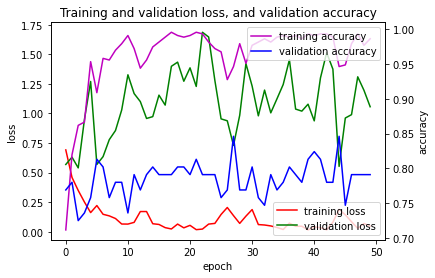

In [25]:
# graph
results_path = ResultPath+'efficientnet_50epoches_adam.pt'
data = torch.load(results_path)
statsrec = data["stats"].cpu().numpy()
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'validation loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss, and validation accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
plt.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# 在验证集上进行预测
def predict(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels), np.array(all_probs)


In [27]:
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [28]:
# 获取预测结果、真实标签和预测概率
predictions, labels, probs = predict(efficientnetmodel, valid_loader)

# 计算混淆矩阵
confusion_mat = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
print(confusion_mat)
print("============================================")

# 计算分类报告
class_names = ['DR grade 0', 'DR grade 1', 'DR grade 2']
classification_rep = classification_report(labels, predictions, target_names=class_names)
print("Classification Report:")
print(classification_rep)


Confusion Matrix:
[[43  2  0]
 [13 25  0]
 [ 0  4  4]]
Classification Report:
              precision    recall  f1-score   support

  DR grade 0       0.77      0.96      0.85        45
  DR grade 1       0.81      0.66      0.72        38
  DR grade 2       1.00      0.50      0.67         8

    accuracy                           0.79        91
   macro avg       0.86      0.70      0.75        91
weighted avg       0.80      0.79      0.78        91



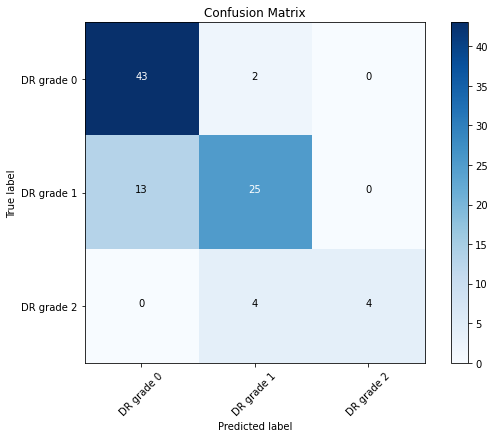

In [29]:
import itertools
# 用图像显示混淆矩阵
plot_confusion_matrix(confusion_mat, classes=class_names)


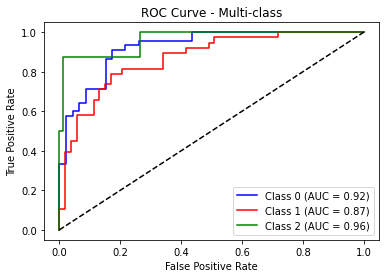

Mean ROC-AUC Score: 0.9180


In [30]:
from sklearn.metrics import roc_curve, auc
# 计算每个类别的ROC曲线和ROC-AUC分数
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制每个类别的ROC曲线
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend()
plt.show()

# 计算平均ROC-AUC分数
mean_roc_auc = np.mean(list(roc_auc.values()))
print(f"Mean ROC-AUC Score: {mean_roc_auc:.4f}")

In [31]:
def test(model, test_loader, criterion):
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # 移动到模型所在的设备
            log_ps = model(images)
            test_loss += criterion(log_ps, labels).item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    return test_loss / len(test_loader), accuracy / len(test_loader)


In [32]:
# 加载模型
model = efficientnetmodel
checkpoint = torch.load(ResultPath+'efficientnet_50epoches_adam.pt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# 如果有GPU则使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义损失函数
criterion = torch.nn.CrossEntropyLoss() # 或者你训练时使用的损失函数

# 运行测试
test_loss, accuracy = test(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f}.. "
      f"Test Accuracy: {accuracy:.3f}")

Test Loss: 1.553.. Test Accuracy: 0.788
